# USDA NASS Honey Bee Data Analysis

## DataSource

**DataSource** https://www.kaggle.com/datasets/kyleahmurphy/nass-honey-bee-20152021?select=Info-NASS_Bee-Stressors_2015-2021.txt
- Data is from 2015-2021 for bee colonies, bee stressors, and honey production.

**About Dataset** 
- Data is collected from the USDA NASS program which releases data on honey bee colonies, stressors, and honey production annually.
- Data is sorted into US States and yearly quarters as well as a cumulative for the United States.
- Each of the 3 files contains data ranging from 2015-2021. 
- _NASS_Bee-Colony_2015-2021.csv_ :- This report provides information on honey bee colonies in terms of number of colonies, maximum, lost, percent lost, added, renovated, and percent renovated, as well as colonies lost with Colony Collapse Disorder symptoms with both over and less than five colonies.
- _NASS_Bee-Honey_2015-2021.csv_ :- This file contains the annual report of the number of colonies producing honey, yield per colony, honey production, average price, price by color class and value; honey stocks by state and US.The report also notes trends and changes in the honey producing sector, such as percent change in honey prices or quantity of production.
- _NASS_Bee-Stressors_2015-2021.csv_ :- The report identifies colony health stressors with five or more colonies.



## Objective

Using **Google Cloud Platform's Cloud Dataproc** to perform big data analysis to answer questions on honey production and impacts of stressors on production and colony loss.

- Exploratory Data Analysis 

    - Top 5 states with highest honey production and lowest honey production.
    - Top 20 states with highest yield.
    - How Stock rates compare with Honey production and what is the trend over years?
    - How does bee stressors impact the honey production?
    - How has colony loss changed over years and in various states?
- Machine Learning Models
    
    - Predict _Lost Colonies_ using _Starting Colonies_ and _Bee Stressors_
    - Predict _Value of Production_ using _Starting Colonies_ and _Yield_
    - Predict _Lost Colonies_ using _Regions_,_Starting Colonies_ and _Bee Stressors_
    - Cluster states into _Regions_ based on _Bee Stressors_
    

In [1]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.functions import col, row_number, expr, when,\
desc, first, last, row_number, rank, substring
from pyspark.sql.functions import max as pmax, min as pmin, split, round
import pyspark.sql.functions as func
import pyspark as ps

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt


import numpy as np
import seaborn as sns
import pandas as pd
import math


from itertools import count 


from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.feature import StandardScaler

from pyspark.sql.functions import mean as _mean, stddev as _stddev, col

import pyspark.sql.functions as f



To run from GCP

In [2]:
beeColonyFile = "gs://dataproc-staging-us-central1-681515474806-zxz9an0t/NASS_Bee-Colony_2015-2021.csv"
beeHoneyFile = "gs://dataproc-staging-us-central1-681515474806-zxz9an0t/NASS_Bee-Honey_2015-2021.csv"
beeStressorFile = "gs://dataproc-staging-us-central1-681515474806-zxz9an0t/NASS_Bee-Stressors_2015-2021.csv"

To run locally place the attached _Data_ folder in the same location as the notebook.

In [2]:
beeColonyFile = "Data/NASS_Bee-Colony_2015-2021.csv"
beeHoneyFile = "Data/NASS_Bee-Honey_2015-2021.csv"
beeStressorFile = "Data/NASS_Bee-Stressors_2015-2021.csv"

In [3]:
spark = SparkSession.builder.config('spark.port.maxRetries', 100).getOrCreate()

## Preprocessing

#### Bee Colony

In [4]:
beeColonyDFO = spark.read.csv(
 beeColonyFile,
 header=True, inferSchema=True,
)
beeColonyDFO = beeColonyDFO.withColumnRenamed("Year", "YearQ")

beeColonyDFO = beeColonyDFO.withColumnRenamed("Year", "YearQ")\
.withColumnRenamed("Starting Colonies", "StartingColonies")\
.withColumnRenamed("Maximum Colonies", "MaximumColonies")\
.withColumnRenamed("Lost Colonies", "LostColonies")\
.withColumnRenamed("Percent Loss", "PercentLoss")\
.withColumnRenamed("Added Colonies", "AddedColonies")\
.withColumnRenamed("Renovated Colonies", "RenovatedColonies")\
.withColumnRenamed("Percent Renovated", "PercentRenovated")

beeColonyDF = beeColonyDFO.withColumn("Year", split(beeColonyDFO['YearQ'], '-').getItem(0)).\
withColumn("Quarter", split(beeColonyDFO['YearQ'], '-').getItem(1))

#Replace x, z, and empty rows
for column in beeColonyDF.columns:
    beeColonyDF = beeColonyDF.withColumn(column, when(beeColonyDF[column] == '(X)', 0).when(beeColonyDF[column] == '(Z)', 0).when(beeColonyDF[column] == '', 0).otherwise(beeColonyDF[column]))
#Cast values as double
for column in beeColonyDF.columns[1:8]:
    beeColonyDF = beeColonyDF.withColumn(column, beeColonyDF[column].cast('double'))
#replace 0s with mean  
for column in beeColonyDF.columns[1:8]:
    mean = beeColonyDF.select(_mean(col(column)).alias('avg')).toPandas().avg[0].round(2)
    beeColonyDF = beeColonyDF.withColumn(column, when(beeColonyDF[column] == 0, mean).otherwise(beeColonyDF[column]))

   

In [5]:
beeColonyDF.show(20)

+-------------+----------------+---------------+------------+-----------+-------------+-----------------+----------------+-------+----+-------+
|        State|StartingColonies|MaximumColonies|LostColonies|PercentLoss|AddedColonies|RenovatedColonies|PercentRenovated|  YearQ|Year|Quarter|
+-------------+----------------+---------------+------------+-----------+-------------+-----------------+----------------+-------+----+-------+
|      Alabama|          7000.0|         7000.0|      1800.0|       26.0|       2800.0|            250.0|             4.0|2015-Q1|2015|     Q1|
|      Arizona|         35000.0|        35000.0|      4600.0|       13.0|       3400.0|           2100.0|             6.0|2015-Q1|2015|     Q1|
|     Arkansas|         13000.0|        14000.0|      1500.0|       11.0|       1200.0|             90.0|             1.0|2015-Q1|2015|     Q1|
|   California|       1440000.0|      1690000.0|    255000.0|       15.0|     250000.0|         124000.0|             7.0|2015-Q1|2015| 

#### Bee Honey

In [6]:
beeHoneyDFO = spark.read.csv(
 beeHoneyFile,
 header=True, inferSchema=True,
)
beeHoneyDFO = beeHoneyDFO.na.fill(0)

#Remove the United States row as it the sum of all the states
beeHoneyDF = beeHoneyDFO.filter(beeHoneyDFO.State != "United States")
#Convert all values to float if not year or state
for column in beeHoneyDF.columns[1:-1]:
    beeHoneyDF = beeHoneyDF.withColumn(column, beeHoneyDF[column].cast('double'))

# Renaming Columns
beeHoneyDF = beeHoneyDF.withColumnRenamed(
    "Honey producing colonies (thousand)","Colonies")\
.withColumnRenamed("Yield per colony (pounds)", "Yield")\
.withColumnRenamed("Production (1,000 pounds)", "Production")\
.withColumnRenamed("Stocks December 15  (1,000 pounds) ", "Stocks")\
.withColumnRenamed("Average price per pound (dollars)", "AvgPrice")\
.withColumnRenamed("Value of production (1,000 dollars)", "Value")

#Replacing 0 values with mean
for column in beeHoneyDF.columns[1:6]:
    mean = beeHoneyDF.select(_mean(col(column)).alias('avg')).toPandas().avg[0].round(2)
    beeHoneyDF = beeHoneyDF.withColumn(column, when(beeHoneyDF[column] == 0, mean).otherwise(beeHoneyDF[column]))

In [7]:
beeHoneyDF.show(20)

+-----------+--------+-----+----------+------+--------+-------+----+
|      State|Colonies|Yield|Production|Stocks|AvgPrice|  Value|Year|
+-----------+--------+-----+----------+------+--------+-------+----+
|    Alabama|     7.0| 47.0|     329.0|  13.0|    3.83| 1260.0|2015|
|    Arizona|    26.0| 49.0|    1274.0| 306.0|    2.17| 2765.0|2015|
|   Arkansas|    24.0| 72.0|    1728.0| 121.0|    2.02| 3491.0|2015|
| California|   275.0| 30.0|    8250.0|1485.0|    2.04|16830.0|2015|
|   Colorado|    29.0| 51.0|    1479.0| 399.0|    2.18| 3224.0|2015|
|    Florida|   220.0| 54.0|   11880.0| 832.0|    1.97|23404.0|2015|
|    Georgia|    69.0| 40.0|    2760.0| 221.0|    2.42| 6679.0|2015|
|     Hawaii|    14.0|102.0|    1428.0|  71.0|    1.95| 2785.0|2015|
|      Idaho|    89.0| 32.0|    2848.0|1082.0|    1.92| 5468.0|2015|
|   Illinois|     8.0| 51.0|     408.0| 155.0|    4.32| 1763.0|2015|
|    Indiana|     6.0| 53.0|     318.0| 165.0|    3.38| 1075.0|2015|
|       Iowa|    36.0| 50.0|    18

In [8]:
beeStressorDFO = spark.read.csv(
 beeStressorFile,
 header=True, inferSchema=True,
)
beeStressorDFO = beeStressorDFO.na.fill(0)
beeStressorDFO = beeStressorDFO.withColumnRenamed("Year", "YearQ")\
.withColumnRenamed("Varroa Mites (Percent)", "VarroaMites")\
.withColumnRenamed("Other pests and parasites (Percent)", "PestParasite")\
.withColumnRenamed("Diseases (percent)", "Diseases")\
.withColumnRenamed("Pesticides (percent)", "Pesticides")\
.withColumnRenamed("Other (percent)", "Other")\
.withColumnRenamed("Unknown (percent)", "Unknown")

beeStressorDF = beeStressorDFO.withColumn("Year", split(beeStressorDFO['YearQ'], '-').getItem(0)).\
withColumn("Quarter", split(beeStressorDFO['YearQ'], '-').getItem(1))

#replace z, na and empty cells with 0
for column in beeStressorDF.columns:
    beeStressorDF = beeStressorDF.withColumn(column, when(beeStressorDF[column] == '(X)', 0).when(beeStressorDF[column] == '(Z)', 0).when(beeStressorDF[column] == ('NA'), 0).otherwise(beeStressorDF[column]))


#Cast values as double
for column in beeStressorDF.columns[1:7]:
    beeStressorDF = beeStressorDF.withColumn(column, beeStressorDF[column].cast('double'))

    
#Replacing 0 values with mean
for column in beeStressorDF.columns[1:7]:
    mean = beeStressorDF.select(_mean(col(column)).alias('avg')).toPandas().avg[0].round(2)
    beeStressorDF = beeStressorDF.withColumn(column, when(beeStressorDF[column] == 0, mean).otherwise(beeStressorDF[column]))

In [9]:
beeStressorDF.show(20)

+-------------+-----------+------------+--------+----------+-----+-------+-------+----+-------+
|        State|VarroaMites|PestParasite|Diseases|Pesticides|Other|Unknown|  YearQ|Year|Quarter|
+-------------+-----------+------------+--------+----------+-----+-------+-------+----+-------+
|      Alabama|       10.0|         5.4|    3.66|       2.2|  9.1|    9.4|2015-Q1|2015|     Q1|
|      Arizona|       26.9|        20.5|     0.1|       6.5|  1.8|    3.1|2015-Q1|2015|     Q1|
|     Arkansas|       17.6|        11.4|     1.5|       3.4|  1.0|    1.0|2015-Q1|2015|     Q1|
|   California|       24.7|         7.2|     3.0|       7.5|  6.5|    2.8|2015-Q1|2015|     Q1|
|     Colorado|       14.6|         0.9|     1.8|       0.6|  2.6|    5.9|2015-Q1|2015|     Q1|
|  Connecticut|        2.5|         1.4|    3.66|       6.5| 21.2|    2.4|2015-Q1|2015|     Q1|
|      Florida|       22.3|        13.5|     0.8|       8.9|  5.1|    4.4|2015-Q1|2015|     Q1|
|      Georgia|        6.2|         4.9|

#### Regions

In [10]:
#Break the states into regions
#Creates a new dataframe to join states on regions
regions = {'Northeast': ['Maine', 'Massachusetts', 'Rhode Island', 'Connecticut', 'New Hampshire', 'Vermont', 'New York', 'Pennsylvania', 'New Jersey', 'Delaware', 'Maryland'],\
          'Southeast' : ['West Virginia', 'Virginia', 'Kentucky', 'Tennessee', 'North Carolina', 'South Carolina', 'Georgia', 'Alabama', 'Mississippi', 'Arkansas', 'Louisiana', 'Florida'],\
           'Midwest' : ['Ohio', 'Indiana', 'Michigan', 'Illinois', 'Missouri', 'Wisconsin', 'Minnesota', 'Iowa', 'Kansas', 'Nebraska', 'South Dakota', 'North Dakota'],\
           'Southwest' : ['Texas', 'Oklahoma', 'New Mexico', 'Arizona'],\
           'West' : ['Colorado', 'Wyoming', 'Montana', 'Idaho', 'Washington', 'Oregon', 'Utah', 'Nevada', 'California', 'Alaska', 'Hawaii']
          }
columnData = []
for key in regions.keys():
    for val in regions[key]:
        columnData.append((val, key))

regionDF = spark.createDataFrame(columnData).toDF("State", "Region")
regionCount = len(regions.keys())
regionDF.show(50)


+--------------+---------+
|         State|   Region|
+--------------+---------+
|         Maine|Northeast|
| Massachusetts|Northeast|
|  Rhode Island|Northeast|
|   Connecticut|Northeast|
| New Hampshire|Northeast|
|       Vermont|Northeast|
|      New York|Northeast|
|  Pennsylvania|Northeast|
|    New Jersey|Northeast|
|      Delaware|Northeast|
|      Maryland|Northeast|
| West Virginia|Southeast|
|      Virginia|Southeast|
|      Kentucky|Southeast|
|     Tennessee|Southeast|
|North Carolina|Southeast|
|South Carolina|Southeast|
|       Georgia|Southeast|
|       Alabama|Southeast|
|   Mississippi|Southeast|
|      Arkansas|Southeast|
|     Louisiana|Southeast|
|       Florida|Southeast|
|          Ohio|  Midwest|
|       Indiana|  Midwest|
|      Michigan|  Midwest|
|      Illinois|  Midwest|
|      Missouri|  Midwest|
|     Wisconsin|  Midwest|
|     Minnesota|  Midwest|
|          Iowa|  Midwest|
|        Kansas|  Midwest|
|      Nebraska|  Midwest|
|  South Dakota|  Midwest|
|

## Statistical Analysis


#### Top 5 states that produces maximum and minimum honey

In [11]:
from pyspark.sql.functions import min, max
print("Top 5 States with Highest Honey Production across years")
beeHoneyDF.groupBy('State').agg(max('Production')).sort(
    ('max(Production)')).select('State',
                          col('max(Production)').alias('Highest Production')).sort(
                              desc('Highest Production')).show(5)
print("********************************************************")
print("Top 5 States with Lowest Honey Production across years")
beeHoneyDF.groupBy('State').agg(max('Production')).sort(
    ('max(Production)')).select('State',
                          col('max(Production)').alias('Lowest Production')).sort(
                              ('Lowest Production')).show(5)

Top 5 States with Highest Honey Production across years
+------------+------------------+
|       State|Highest Production|
+------------+------------------+
|North Dakota|           38610.0|
|South Dakota|           19880.0|
|  California|           16080.0|
|     Montana|           14878.0|
|     Florida|           11880.0|
+------------+------------------+
only showing top 5 rows

********************************************************
Top 5 States with Lowest Honey Production across years
+-------------+-----------------+
|        State|Lowest Production|
+-------------+-----------------+
|     Virginia|            228.0|
|     Kentucky|            246.0|
|West Virginia|            276.0|
|      Vermont|            336.0|
|      Alabama|            364.0|
+-------------+-----------------+
only showing top 5 rows



**Inferences**
1. North Dakota is the top honey-producing state in the USA.
2. Followed by South Dakota, California, Montana and Florida.
3. Virginia produces the least honey followed by Kentucky, West Virgnia, Vermont and Albama.

#### Top 20 States with highest yield and the respective year

In [12]:
beeHoneyDF.groupBy('Year', 'State').sum('Yield').select(
    'Year', 'State',
    col('sum(Yield)').alias('Total Yield')).orderBy(
        col('Total Yield').desc()).show(20)

+----+-----------+-----------+
|Year|      State|Total Yield|
+----+-----------+-----------+
|2017|     Hawaii|      131.0|
|2016|     Hawaii|      113.0|
|2020|     Hawaii|      105.0|
|2018|     Hawaii|      103.0|
|2015|     Hawaii|      102.0|
|2015|  Louisiana|       99.0|
|2018|    Montana|       92.0|
|2018|Mississippi|       87.0|
|2019|    Montana|       86.0|
|2016|  Louisiana|       86.0|
|2016|Mississippi|       85.0|
|2015|Mississippi|       83.0|
|2015|    Montana|       83.0|
|2018|  Louisiana|       83.0|
|2017|  Louisiana|       81.0|
|2020|    Montana|       81.0|
|2017|Mississippi|       80.0|
|2019|     Hawaii|       80.0|
|2019|Mississippi|       80.0|
|2017|     Kansas|       79.0|
+----+-----------+-----------+
only showing top 20 rows



**Inferences**
1. Hawaii has the highest yield per colony for most years from 2015 through 2020 except 2019.
2. For year 2019, Montana had the highest yield but hawaii is still not bad for year 2019. It had still made it to Top 20.
3. Hawaii, Lousinana, Montana and Missisiippi comes in the top 20 states with highest yield per colony.

#### For each year, what is the largest  and the smallest production along with that respective State

In [13]:
beehoney_high_low = beeHoneyDF.select([
    'State', 'Year',
    beeHoneyDF['Production'].alias('HighProd'), 
    beeHoneyDF['Production'].alias('LowProd')
])
#beehoney_high_low.show(5)

In [14]:
windowHigh = Window.partitionBy("Year").orderBy(desc("HighProd"))
high = beehoney_high_low.withColumn(
    "row_number",
    row_number().over(windowHigh)).filter("row_number == 1").select(
        ['State', 'HighProd', 'Year'])

windowLow = Window.partitionBy("Year").orderBy("LowProd")
low = beehoney_high_low.withColumn(
    "row_number",
    row_number().over(windowLow)).filter("row_number == 1").select(
        ['State', 'LowProd', 'Year'])

high.join(low, on='Year', how='outer').show()

+----+------------+--------+-------------+-------+
|Year|       State|HighProd|        State|LowProd|
+----+------------+--------+-------------+-------+
|2018|North Dakota| 38160.0|     Virginia|  160.0|
|2015|North Dakota| 36260.0|West Virginia|  175.0|
|2019|North Dakota| 33800.0|     Virginia|  195.0|
|2020|North Dakota| 38610.0|     Virginia|  200.0|
|2016|North Dakota| 37830.0|West Virginia|  160.0|
|2017|North Dakota| 33670.0|     Virginia|  175.0|
+----+------------+--------+-------------+-------+



**Inferences**
1. North Dakota had the highest production for all years.
2. West Virginia and Virginia had the lowest production for all years.

#### Stock Rates versus Production

##### For the highest production year (2020) what states has the 5 highest stocks

In [15]:
high_prod = beeHoneyDF[beeHoneyDF.Year==2020].sort("Production",ascending=False).limit(5)
high_prod.show()

+------------+--------+-----+----------+------+--------+-------+----+
|       State|Colonies|Yield|Production|Stocks|AvgPrice|  Value|Year|
+------------+--------+-----+----------+------+--------+-------+----+
|North Dakota|   495.0| 78.0|   38610.0|8108.0|     1.6|61776.0|2020|
|South Dakota|   245.0| 61.0|   14945.0|8668.0|     1.6|23912.0|2020|
|  California|   320.0| 43.0|   13760.0|2752.0|    1.78|24493.0|2020|
|       Texas|   157.0| 57.0|    8949.0|1253.0|     1.9|17003.0|2020|
|     Montana|   110.0| 81.0|    8910.0|3208.0|    1.57|13989.0|2020|
+------------+--------+-----+----------+------+--------+-------+----+



##### For the highest production year (2020) what states has the 5 least stocks

In [16]:
low_prod = beeHoneyDF[beeHoneyDF.Year==2020].sort("Stocks").limit(6)
low_prod.show()

+--------------+--------+-----+----------+------+--------+------+----+
|         State|Colonies|Yield|Production|Stocks|AvgPrice| Value|Year|
+--------------+--------+-----+----------+------+--------+------+----+
|     Tennessee|     7.0| 51.0|     357.0|  54.0|    4.39|1567.0|2020|
|      Virginia|     5.0| 40.0|     200.0|  54.0|    5.44|1088.0|2020|
|      Kentucky|     7.0| 33.0|     231.0|  58.0|    6.25|1444.0|2020|
| West Virginia|     6.0| 46.0|     276.0|  58.0|    3.89|1074.0|2020|
|       Alabama|     7.0| 39.0|     273.0|  66.0|    5.43|1482.0|2020|
|South Carolina|    16.0| 46.0|     736.0|  66.0|    3.28|2414.0|2020|
+--------------+--------+-----+----------+------+--------+------+----+



**Inferences**
1. Stocks held by Producer follows the pattern of Production.
2. Highest number of stocks are held for South Dakota followed by North Dakota.
3. Top 5 states with highest production are also the states with highest stocks.
4. For the lowest stocks, Tennesse is in the top.Follwed by Virginia, Kentucky, West Virginia and  Alabama which are the least honey producing states.

##### How does Stock Percent compare to Production for year 2015 and 2020

Text(0.5, 1.0, 'Low Production 2020')

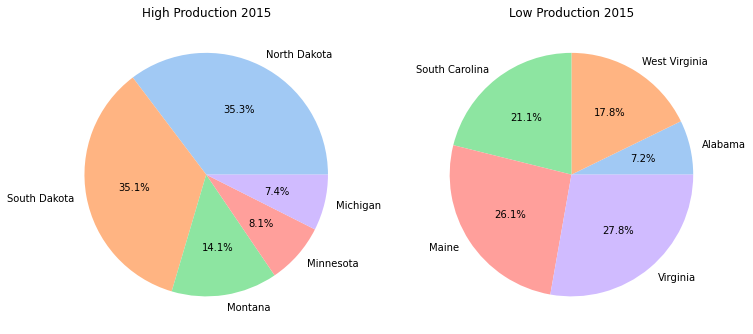

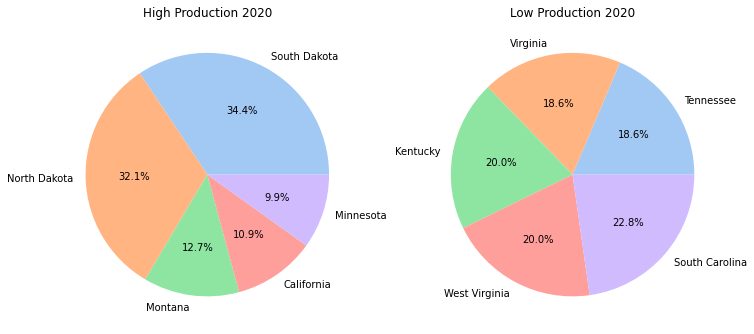

In [17]:
high_prod_2015 = beeHoneyDF[beeHoneyDF.Year==2015].sort("Stocks",ascending=False).limit(5)
high_prod_2020 = beeHoneyDF[beeHoneyDF.Year==2020].sort("Stocks",ascending=False).limit(5)

low_prod_2015 = beeHoneyDF[beeHoneyDF.Year==2015].sort("Stocks").limit(5)
low_prod_2020 = beeHoneyDF[beeHoneyDF.Year==2020].sort("Stocks").limit(5)

palette_color = sns.color_palette('pastel')
  

high_prodDF_2015 = high_prod_2015.toPandas()
high_prod_2015.num_stocks = [int(each) for each in high_prodDF_2015["Stocks"]]
high_labels_2015 = high_prodDF_2015.State


low_prodDF_2015 = low_prod_2015.toPandas()
low_prod_2015.num_stocks = [int(each) for each in low_prodDF_2015["Stocks"]]
low_labels_2015 = low_prodDF_2015.State

high_prodDF_2020 = high_prod_2020.toPandas()
high_prod_2020.num_stocks = [int(each) for each in high_prodDF_2020["Stocks"]]
high_labels_2020 = high_prodDF_2020.State


low_prodDF_2020 = low_prod_2020.toPandas()
low_prod_2020.num_stocks = [int(each) for each in low_prodDF_2020["Stocks"]]
low_labels_2020 = low_prodDF_2020.State

fig, axs = plt.subplots(1, 2, figsize=(12, 8))

axs[0].pie(high_prod_2015.num_stocks,labels = high_labels_2015, colors = palette_color, autopct = '%1.1f%%')
axs[0].set_title('High Production 2015')
axs[1].pie(low_prod_2015.num_stocks,labels = low_labels_2015, colors = palette_color, autopct = '%1.1f%%')
axs[1].set_title('Low Production 2015')

fig, axs = plt.subplots(1, 2, figsize=(12, 8))

axs[0].pie(high_prod_2020.num_stocks,labels = high_labels_2020, colors = palette_color, autopct = '%1.1f%%')
axs[0].set_title('High Production 2020')
axs[1].pie(low_prod_2020.num_stocks,labels = low_labels_2020, colors = palette_color, autopct = '%1.1f%%')
axs[1].set_title('Low Production 2020')

**Inferences**
1. Michigan dropped off from the top 5 states with highest stocks in 5 years and California made it to top 5.
2. Maine which was having second highest stocks got dropped from top 5 for least producing states.
3. Virginia has dropped from the highest stock holding states in lowest production category to 4th place.

#### Impact of Bee Stressors by year and quarter

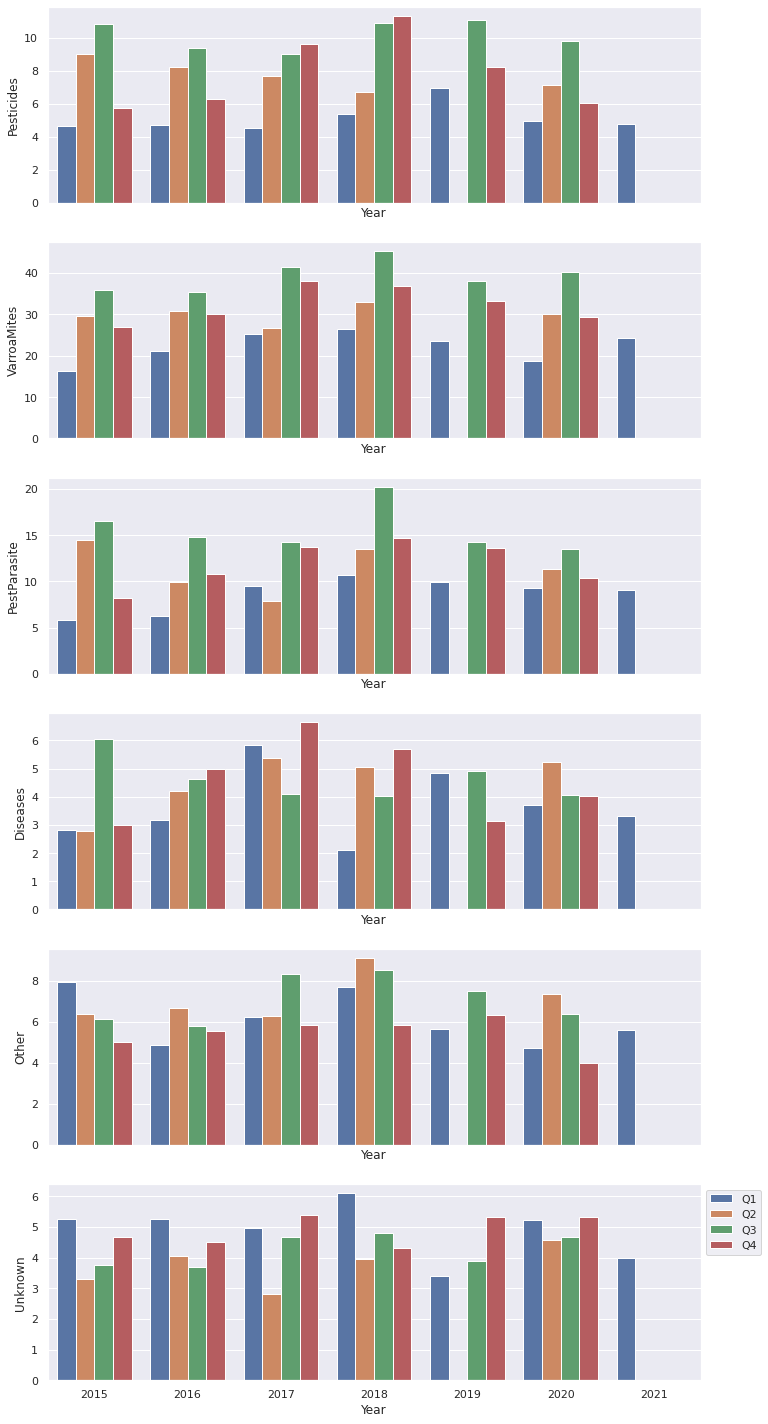

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

df = beeStressorDF.toPandas()
# plot with seaborn barplot
sns.set(rc={'figure.figsize':(11.7,25.27)})
f, axarr = plt.subplots(6, sharex=True)
#sns.lineplot(x="Year", y="Pesticides", data=df, marker="o", ax=axarr[0])
sns.barplot(x="Year", y="Pesticides", data=df, ax=axarr[0], hue='Quarter',ci=None)
sns.barplot(x="Year", y="VarroaMites", data=df, ax=axarr[1], hue='Quarter',ci=None)
sns.barplot(x="Year", y="PestParasite", data=df, ax=axarr[2], hue='Quarter',ci=None)
sns.barplot(x="Year", y="Diseases", data=df, ax=axarr[3], hue='Quarter',ci=None)
sns.barplot(x="Year", y="Other", data=df, ax=axarr[4], hue='Quarter',ci=None)
sns.barplot(x="Year", y="Unknown", data=df, ax=axarr[5], hue='Quarter',ci=None) 
#sns.barplot(data=df, x='Year', y='Pesticides (percent)', hue='Quarter')


for ax in axarr:
    ax.legend([],[], frameon=False)
axarr[5].legend(bbox_to_anchor=(1, 1), loc=2)

**Inferences**
1. Varroa Mites,Other pests and parasites,Pesticides are the main stressors.
2. Diseases, Other and Unknown stressors contribute to less than 10%.
3. Looking at the highest 3 stressors, the impact is the highest in the third quarter and lowest in the first.
4. For other stressors the impact across quarters are random.
5. Year-2018 has the highest impact from all the stressors.

#### Top 5 states with highest and lowest  stress impact for every year

In [19]:
import pyspark.sql.functions as F
stressors = ["Pesticides", "VarroaMites", "PestParasite","Diseases","Other","Unknown"]
beeStressorDF2 = beeStressorDF.dropna()
beeStressorDF2 = beeStressorDF2.withColumn(
    'TotalStress',
    sum([F.col(c) for c in stressors])
)
#beeStressorDF2.show(5)

print("Top 5 Highest Stress states")
beeStressorDF2.orderBy('TotalStress',ascending= False).show(5)
print("Top 5 Lowest Stress states")
beeStressorDF2.orderBy('TotalStress').show(5)

Top 5 Highest Stress states
+------------+-----------+------------+--------+----------+-----+-------+-------+----+-------+------------------+
|       State|VarroaMites|PestParasite|Diseases|Pesticides|Other|Unknown|  YearQ|Year|Quarter|       TotalStress|
+------------+-----------+------------+--------+----------+-----+-------+-------+----+-------+------------------+
|  New Mexico|       61.2|        55.0|    55.0|      58.0| 55.5|    0.7|2015-Q3|2015|     Q3|             285.4|
|     Vermont|       96.6|        44.5|    22.1|      55.2|  5.7|    1.8|2017-Q4|2017|     Q4|             225.9|
|South Dakota|       87.0|         7.0|     2.1|      64.9| 61.4|    2.0|2020-Q3|2020|     Q3|             224.4|
|    Missouri|       86.0|        77.8|     0.3|       3.5| 26.5|   23.9|2018-Q1|2018|     Q1|218.00000000000003|
|     Montana|       59.1|        39.4|    32.9|      13.7| 33.3|   33.1|2016-Q4|2016|     Q4|211.49999999999997|
+------------+-----------+------------+--------+----------+-

#### Change in Total Stressors over years

In [20]:
beeStressorDF2.createOrReplaceTempView('beeStressorDF2_table')

In [21]:
beeStressorDF2 = spark.sql("""
SELECT Year,avg(TotalStress) AS Stress
    FROM beeStressorDF2_table 
    GROUP BY Year
    ORDER BY Year,Stress DESC
""")

In [22]:
beeStressorDF2.show(50)

+----+------------------+
|Year|            Stress|
+----+------------------+
|2015|60.254574468085146|
|2016| 61.29925531914892|
|2017| 68.47787234042553|
|2018|  75.4854255319149|
|2019| 67.93638297872336|
|2020| 62.45047872340421|
|2021| 51.09787234042554|
+----+------------------+



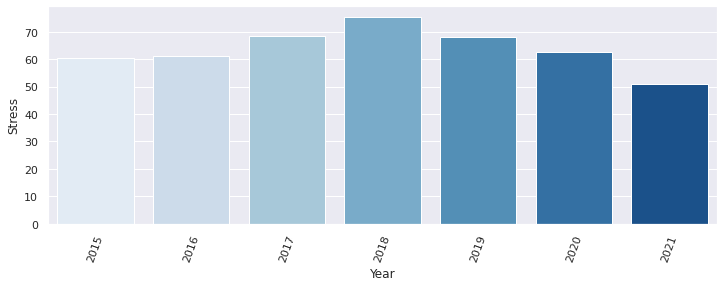

In [23]:
import numpy as np, matplotlib.pyplot as plt, seaborn as sns
sns.set(style="whitegrid", color_codes=True)
sns.set(rc={'figure.figsize':(12,4)})
beeStressordf2 = beeStressorDF2.toPandas()
data = beeStressordf2['Year'].squeeze()

pal = sns.color_palette("Blues_r", len(data))
rank = data.argsort().argsort()
sns.barplot(x=beeStressordf2['Year'], y=beeStressordf2['Stress'], palette=np.array(pal[::-1])[rank])
plt.xticks(rotation=70)
plt.show()

**Inferences**
1. Highest Stress impact can be seen in year 2018 followed by 2017 and 2019.

#### How the Percent Loss  in colonies has changed over years for top 20 States

In [24]:
from pyspark.sql.functions import min, max

print("Top 20 States with Highest Percent Loss across years")
high_loss = beeColonyDF.groupBy('State').agg(max('PercentLoss')).sort(
    ('max(PercentLoss)')).select('State',
                          col('max(PercentLoss)').alias('Highest Loss')).sort(
                              desc('Highest Loss'))
high_loss.show(20)
print("********************************************************")
print("Top 20 States with Lowest Percent Loss across years")
low_loss = beeColonyDF.groupBy('State').agg(max('PercentLoss')).sort(
    ('max(PercentLoss)')).select('State',
                          col('max(PercentLoss)').alias('Lowest Loss')).sort(
                              ('Lowest Loss'))
low_loss.show(20)




Top 20 States with Highest Percent Loss across years
+-------------+------------+
|        State|Highest Loss|
+-------------+------------+
|     Missouri|        65.0|
|   New Mexico|        52.0|
|         Ohio|        48.0|
|      Alabama|        48.0|
|Massachusetts|        45.0|
|     Maryland|        41.0|
|     Illinois|        40.0|
|       Kansas|        40.0|
|     Kentucky|        39.0|
|      Indiana|        37.0|
|     Arkansas|        34.0|
|    Tennessee|        34.0|
|        Maine|        32.0|
|     Michigan|        32.0|
|      Arizona|        31.0|
| Pennsylvania|        31.0|
|     Virginia|        30.0|
|     Colorado|        30.0|
|West Virginia|        30.0|
| South Dakota|        28.0|
+-------------+------------+
only showing top 20 rows

********************************************************
Top 20 States with Lowest Percent Loss across years
+--------------+-----------+
|         State|Lowest Loss|
+--------------+-----------+
|        Oregon|       13.0|


In [25]:
highest_loss_states = list(high_loss.toPandas()['State'][0:3])
lowest_loss_states = list(low_loss.toPandas()['State'][0:3])

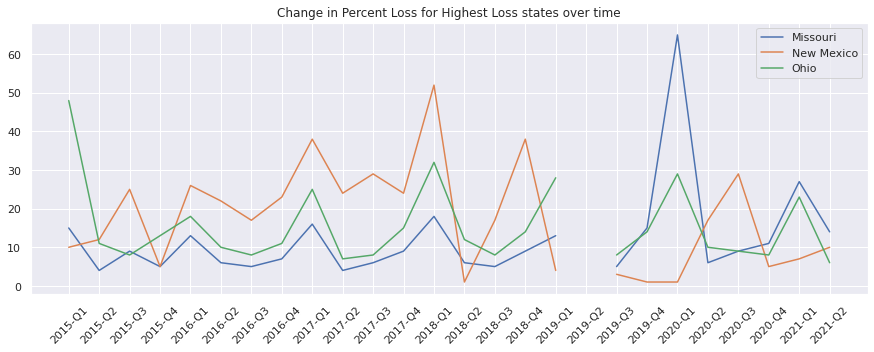

In [26]:
beeColonydf = beeColonyDF.toPandas()
#beeColonydf.plot.line(x="YearQ", y="Percent Loss")
#States = set(beeColonydf['State'])

plt.figure(figsize=(15, 5))
for state in highest_loss_states:
     selected_data = beeColonydf.loc[beeColonydf['State'] == state]
     plt.plot(selected_data['YearQ'], selected_data['PercentLoss'], label=state)
plt.xticks(rotation=45) 
plt.title("Change in Percent Loss for Highest Loss states over time")
plt.legend()
plt.show()

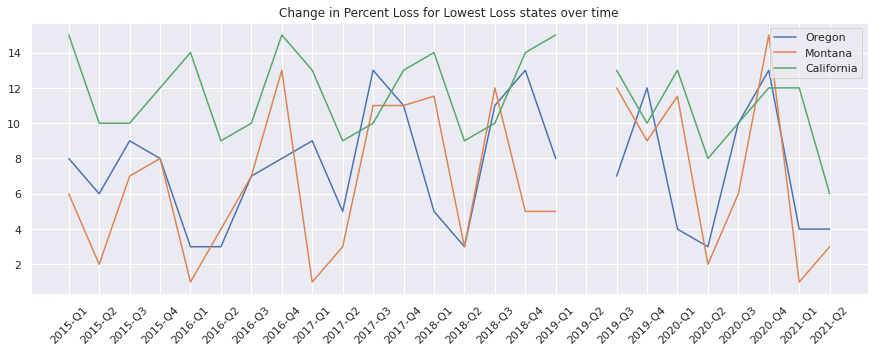

In [27]:
beeColonydf = beeColonyDF.toPandas()
#beeColonydf.plot.line(x="YearQ", y="Percent Loss")
#States = set(beeColonydf['State'])

plt.figure(figsize=(15, 5))
for state in lowest_loss_states:
     selected_data = beeColonydf.loc[beeColonydf['State'] == state]
     plt.plot(selected_data['YearQ'], selected_data['PercentLoss'], label=state)
plt.xticks(rotation=45) 
plt.title("Change in Percent Loss for Lowest Loss states over time")
plt.legend()
plt.show()

#### Percent Loss in the year-2015 and year-2020 for all States

In [28]:
colony_2015 = beeColonyDF.select(
    'State', 'Year', 'Quarter',
    #'Percent Loss').filter( (beeColonyDF.Year  == "2015") & (beeColonyDF.Quarter  == "Q1") )
    'PercentLoss').filter( (beeColonyDF.Year  == "2015") )

colony_2020 = beeColonyDF.select(
    'State', 'Year', 'Quarter',
    #'Percent Loss').filter( (beeColonyDF.Year  == "2015") & (beeColonyDF.Quarter  == "Q1") )
    'PercentLoss').filter( (beeColonyDF.Year  == "2020") )
colony_2015df = colony_2015.toPandas()
colony_2020df = colony_2020.toPandas()

In [29]:
print("Top 10 Percent Loss For Year 2015")
colony_2015.sort(desc('PercentLoss')).show(10)
print()
print("Top 10 Percent Loss For Year 2020")
colony_2020.sort(desc('PercentLoss')).show(10)

Top 10 Percent Loss For Year 2015
+-------------+----+-------+-----------+
|        State|Year|Quarter|PercentLoss|
+-------------+----+-------+-----------+
|         Ohio|2015|     Q1|       48.0|
|     Maryland|2015|     Q1|       41.0|
|     Illinois|2015|     Q1|       40.0|
|       Kansas|2015|     Q4|       40.0|
|     Kentucky|2015|     Q1|       39.0|
|      Arizona|2015|     Q4|       31.0|
| Pennsylvania|2015|     Q1|       31.0|
|West Virginia|2015|     Q1|       30.0|
|     Arkansas|2015|     Q3|       30.0|
|    Wisconsin|2015|     Q1|       28.0|
+-------------+----+-------+-----------+
only showing top 10 rows


Top 10 Percent Loss For Year 2020
+------------+----+-------+-----------+
|       State|Year|Quarter|PercentLoss|
+------------+----+-------+-----------+
|    Missouri|2020|     Q1|       65.0|
|     Alabama|2020|     Q2|       48.0|
|      Kansas|2020|     Q4|       34.0|
|    Michigan|2020|     Q3|       32.0|
|        Ohio|2020|     Q1|       29.0|
|  New Mexi

<AxesSubplot:xlabel='Quarter', ylabel='State'>

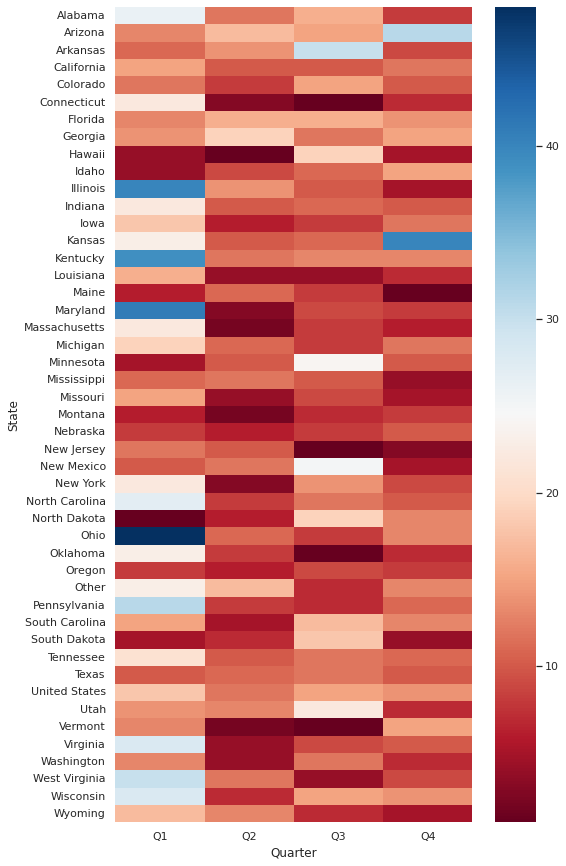

In [30]:
heatmap_data = pd.pivot_table(colony_2015df, values='PercentLoss', 
                     index=['State'], 
                     columns='Quarter')
plt.figure(figsize=(8, 15))
sns.heatmap(heatmap_data, cmap="RdBu")

<AxesSubplot:xlabel='Quarter', ylabel='State'>

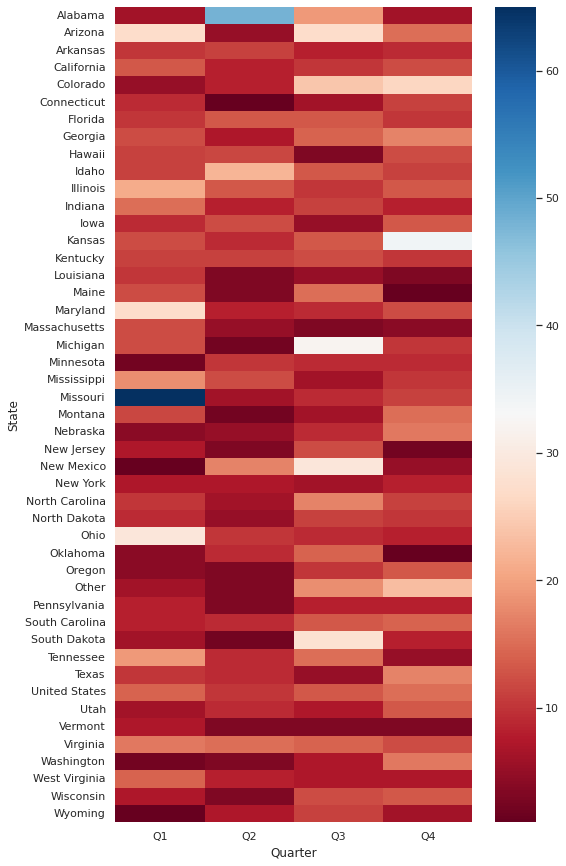

In [31]:
heatmap_data = pd.pivot_table(colony_2020df, values='PercentLoss', 
                     index=['State'], 
                     columns='Quarter')
plt.figure(figsize=(8, 15))
sns.heatmap(heatmap_data, cmap="RdBu")

**Inferences**
1. Percent Loss has decreased significantly in 2020 compared to 2015.
2. In 2015, most of the loss is seen in first quarter.

## Machine Learning

#### Linear Modeling - Bee Stressors + Starting Colonies versus Lost Colonies

In [32]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
#summing up all the quarters per year for each state
beeStressorDFGrouped = beeStressorDF.groupBy("State","Year").sum().sort("State","Year")

beeStressorDFGrouped = beeStressorDFGrouped.withColumnRenamed("sum(VarroaMites)", "Varroa Mites").withColumnRenamed("sum(PestParasite)", "pests and parasites")\
.withColumnRenamed("sum(Diseases)", "Diseases").withColumnRenamed("sum(Pesticides)", "Pesticides").withColumnRenamed("sum(Other)", "Other").withColumnRenamed("sum(Unknown)", "Unknown")


beeStressorDFGrouped.show(5)
#sum up colonies for each state per year

beeColonyDFSelect = beeColonyDF.select("State", "StartingColonies", "LostColonies", "Year")
beeColonyDFGrouped = beeColonyDFSelect.groupBy("State","Year") \
    .sum("StartingColonies", "LostColonies").sort("State","Year")

beeColonyDFGrouped = beeColonyDFGrouped.withColumnRenamed("sum(StartingColonies)", "Starting Colonies").withColumnRenamed("sum(LostColonies)", "Lost Colonies")
beeColonyDFGrouped.show(5)


+-------+----+-----------------+-------------------+-----------------+------------------+------------------+------------------+
|  State|Year|     Varroa Mites|pests and parasites|         Diseases|        Pesticides|             Other|           Unknown|
+-------+----+-----------------+-------------------+-----------------+------------------+------------------+------------------+
|Alabama|2015|92.89999999999999|              124.9|            11.18|               7.3|              17.3|              33.1|
|Alabama|2016|             57.8|  82.10000000000001|8.459999999999999|15.999999999999998|17.099999999999998|33.800000000000004|
|Alabama|2017|            129.6|               55.6|            16.32|              52.3|              25.3|              23.7|
|Alabama|2018|            152.5|              147.4|              5.2|              45.4|              29.2|              20.9|
|Alabama|2019|            104.5|               74.0|              5.3|               5.4|21.799999999999

In [33]:
#joining data
stressNColony = beeColonyDFGrouped.join(beeStressorDFGrouped, on = ["State", "Year"], how = "inner").join(regionDF, on = 'State')
stressNColony.show(5)

vec_assembler = VectorAssembler(
    inputCols = stressNColony.columns[2:-1],
    outputCol = 'inputFeatures',
    )

features_df = vec_assembler.transform(stressNColony)

model_dfCum=features_df.select('inputFeatures','Lost Colonies', 'Region')
for region in regions:
    print("Linear Model for region: " + region)
    model_df = model_dfCum.filter(model_dfCum.Region == region)
    Scalerizer=StandardScaler().setInputCol("inputFeatures").setOutputCol("Scaled_features")

    model_df = Scalerizer.fit(model_df).transform(model_df)

    train_df, test_df = model_df.randomSplit(
        [0.7,0.3], seed = 7666)
    lr = LinearRegression(
        featuresCol='Scaled_features',
        labelCol='Lost Colonies',
        regParam=0.001)

    lr_model=lr.fit(train_df)

    test_predictions = lr_model.evaluate(test_df)
    print("Intercept:", lr_model.intercept)
    print("Coefficients:", lr_model.coefficients)
    print("R2:", test_predictions.r2, 
          "MSE:", test_predictions.meanSquaredError,
          "RMSE:", test_predictions.rootMeanSquaredError)
    test_predictions.residuals.show(5)
    print()




+-------------+----+-----------------+-------------+------------+-------------------+------------------+------------------+------------------+------------------+---------+
|        State|Year|Starting Colonies|Lost Colonies|Varroa Mites|pests and parasites|          Diseases|        Pesticides|             Other|           Unknown|   Region|
+-------------+----+-----------------+-------------+------------+-------------------+------------------+------------------+------------------+------------------+---------+
|        Idaho|2016|         351000.0|      43000.0|       109.9| 12.600000000000001|14.100000000000001|              16.8|              21.0|10.399999999999999|     West|
|    Wisconsin|2017|         160000.0|      29400.0|       147.5|               61.5|54.400000000000006|              48.8|              35.5|38.099999999999994|  Midwest|
|      Alabama|2016|          30500.0|       4440.0|        57.8|  82.10000000000001| 8.459999999999999|15.999999999999998|17.09999999999999

22/04/28 15:31:02 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/04/28 15:31:02 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
22/04/28 15:31:02 WARN com.github.fommil.netlib.LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
22/04/28 15:31:03 WARN com.github.fommil.netlib.LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


Intercept: -0.002635146924301287
Coefficients: [0.011619801324747858,5752.418964645537,0.0006168734390786816,0.0007192737580753218,-0.0016936639886041907,-0.00019607858665784855,0.00020532643840465953,0.0016701124689897276]
R2: 0.9999999999994332 MSE: 1.1937285507596863e-05 RMSE: 0.003455037699880692
+--------------------+
|           residuals|
+--------------------+
|0.004406100869573493|
|0.001588647969128...|
|-0.00211886797194...|
|-0.00100682111087...|
|5.375285802529106E-4|
+--------------------+
only showing top 5 rows


Linear Model for region: Southeast


Intercept: -0.0035852257385455303
Coefficients: [0.034663223314956165,37115.25371044139,-0.0017817063602073339,-3.454046139504591e-05,8.451814983239591e-05,-9.52297093076321e-05,0.001340268332868984,0.003595596450378839]
R2: 0.9999999999999543 MSE: 8.806619413526073e-05 RMSE: 0.009384359015684594
+--------------------+
|           residuals|
+--------------------+
|0.001921495742408...|
|-0.01080661901505664|
|0.007999740360901342|
|-0.00222475601913...|
|-0.00938229182793...|
+--------------------+
only showing top 5 rows


Linear Model for region: Midwest


Intercept: -0.0016281197274581796
Coefficients: [0.018262513847035252,34168.60864942401,0.00010469876047289362,-0.0016538000490180487,0.0005527487606822099,0.0009489467921316945,0.001440861212755374,0.0017610790441625784]
R2: 0.9999999999999414 MSE: 6.678751398640233e-05 RMSE: 0.008172362815392029
+--------------------+
|           residuals|
+--------------------+
|-0.00262376076534...|
|-0.00309056534570...|
|-0.00180800972884...|
|-0.00133745400671...|
|-8.78114591614576...|
+--------------------+
only showing top 5 rows


Linear Model for region: Southwest
Intercept: -0.008699481844725132
Coefficients: [0.04112922870009273,39866.559832746425,0.006551880061871697,0.00011880592144964709,-0.004544687116137997,0.0030287509360314136,-0.0029138488870410224,0.003361733902506224]
R2: 0.9999999999999598 MSE: 3.597777968240982e-05 RMSE: 0.005998148021048649
+--------------------+
|           residuals|
+--------------------+
|-2.32246648920408...|
|3.112262202193960...|
|0.007417231159706716

#### Linear Model - Starting Colonies + Yield versus value of production

In [58]:
# Combining bee starting colonies df with bee honey DF to predict honey production 
colonyNProductionDF = beeColonyDF.join(beeHoneyDF, on = ['State', 'Year']).drop("YearQ")
colonyNProductionDF = colonyNProductionDF.na.fill(0).select('State', 'Year', 'StartingColonies', 'Yield', 'Value')
colonyNProductionDF.show(10, truncate = False)
## Creating Linear Regression Model 

# want to see how much of an influece to stressors have on honey production

#create the vector assembler 
vec_assembler = VectorAssembler(
    inputCols = colonyNProductionDF.columns[2:4],
    outputCol = 'inputFeatures')

#building linear regression model


lr = LinearRegression(
    featuresCol='inputFeatures',
    labelCol='Value',
    regParam=0.001)


+----------+----+----------------+-----+-------+
|State     |Year|StartingColonies|Yield|Value  |
+----------+----+----------------+-----+-------+
|Alabama   |2015|7000.0          |47.0 |1260.0 |
|Arizona   |2015|35000.0         |49.0 |2765.0 |
|Arkansas  |2015|13000.0         |72.0 |3491.0 |
|California|2015|1440000.0       |30.0 |16830.0|
|Colorado  |2015|3500.0          |51.0 |3224.0 |
|Florida   |2015|305000.0        |54.0 |23404.0|
|Georgia   |2015|104000.0        |40.0 |6679.0 |
|Hawaii    |2015|10500.0         |102.0|2785.0 |
|Idaho     |2015|81000.0         |32.0 |5468.0 |
|Illinois  |2015|6000.0          |51.0 |1763.0 |
+----------+----+----------------+-----+-------+
only showing top 10 rows



In [60]:
#transform the values
features_df = vec_assembler.transform(colonyNProductionDF).join(regionDF, on = 'State')
features_df.show()
#creating the model data containing input features and output column
model_dfCum = features_df.select('inputFeatures','Value', 'Region')
for region in regions:
    
    #split the data into 70/30 ratio for train test purpose
    train_df, test_df = model_df.randomSplit([0.7,0.3], seed = 777)
    
    model_df = model_dfCum.filter(model_dfCum.Region == region)

    print("Model for region: " + region)
    #fit the linear regression model on training data set 

    lr_model=lr.fit(model_df)

    lr_model

    # intercept of model 

    # when all the stressors are 0, this is the value of the production (1,000) pounds 
    print("this is the model's intercept:",lr_model.intercept)

    # coefficients of model

    # the size of the affect each stressor variable has on Honey production
    # and positive/negative values shows the dirrection of the affect

    print("these are the model's coefficients",lr_model.coefficients)
    # order of the stressors: Varroa Mites (Percent), Other pests and parasites (Percent), Diseases (percent), Pesticides (percent),
    #Other (percent), Unknown (percent)

    #make predictions on test data 

    test_results = lr_model.evaluate(model_df)

    print("test R^2 value:",test_results.r2)
    print("test mean squared error value:",test_results.meanSquaredError)
    print("test root mean squared error value:",test_results.rootMeanSquaredError)
    
    test_results.residuals.show(5)


 #   lr_predictions = lr_model.transform(test_df)
  #  lrevaluator = RegressionEvaluator(
  #      predictionCol="prediction", 
  #      labelCol="Value", 
  #      metricName="rmse")


  #  lrevaluator.evaluate(lr_predictions)

+-----+----+----------------+-----+------+--------------+------+
|State|Year|StartingColonies|Yield| Value| inputFeatures|Region|
+-----+----+----------------+-----+------+--------------+------+
| Utah|2015|          6000.0| 42.0|2189.0| [6000.0,42.0]|  West|
| Utah|2015|         24000.0| 42.0|2189.0|[24000.0,42.0]|  West|
| Utah|2015|         31000.0| 42.0|2189.0|[31000.0,42.0]|  West|
| Utah|2015|         28000.0| 42.0|2189.0|[28000.0,42.0]|  West|
| Utah|2016|         12000.0| 32.0|1895.0|[12000.0,32.0]|  West|
| Utah|2016|         14500.0| 32.0|1895.0|[14500.0,32.0]|  West|
| Utah|2016|         27000.0| 32.0|1895.0|[27000.0,32.0]|  West|
| Utah|2016|         30000.0| 32.0|1895.0|[30000.0,32.0]|  West|
| Utah|2017|         16000.0| 31.0|1724.0|[16000.0,31.0]|  West|
| Utah|2017|         21000.0| 31.0|1724.0|[21000.0,31.0]|  West|
| Utah|2017|         35000.0| 31.0|1724.0|[35000.0,31.0]|  West|
| Utah|2017|         29000.0| 31.0|1724.0|[29000.0,31.0]|  West|
| Utah|2018|          750

## Random Forest Classifier;  Input: Stress, Output: Region

In [37]:
rf2_stressNcolony = stressNColony.select("Varroa Mites", "pests and parasites", "Diseases", "Pesticides", "Other", "Unknown", "Region")

In [38]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.classification import RandomForestClassifier

rf_model = RandomForestClassifier(labelCol="label", numTrees=100)

stringIndexer = StringIndexer(inputCols=["Region"], outputCols=["label"])

vec_assembler = VectorAssembler(
    inputCols = rf2_stressNcolony.columns[0:6],
    outputCol = 'features')

rf_p = Pipeline(stages=[stringIndexer, vec_assembler, rf_model])
rf_model = rf_p.fit(rf2_stressNcolony)
predictions = rf_model.transform(rf2_stressNcolony)
predictions.show(5)

evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator_accuracy.evaluate(predictions)

evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
precision = evaluator_precision.evaluate(predictions)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Feature Imortance:", rf_model.stages[-1].featureImportances)
print("Classifier information:", rf_model.stages[-1])

+------------+-------------------+------------------+------------------+------------------+------------------+---------+-----+--------------------+--------------------+--------------------+----------+
|Varroa Mites|pests and parasites|          Diseases|        Pesticides|             Other|           Unknown|   Region|label|            features|       rawPrediction|         probability|prediction|
+------------+-------------------+------------------+------------------+------------------+------------------+---------+-----+--------------------+--------------------+--------------------+----------+
|       109.9| 12.600000000000001|14.100000000000001|              16.8|              21.0|10.399999999999999|     West|  2.0|[109.9,12.6000000...|[20.2177624322992...|[0.20217762432299...|       2.0|
|       147.5|               61.5|54.400000000000006|              48.8|              35.5|38.099999999999994|  Midwest|  0.0|[147.5,61.5,54.40...|[37.3068039192847...|[0.37306803919284...|       

## Random Forest Regressor: Input = One Hot Encoded Regions + Starting Colonies + Stressors; Output = Lost Colonies

In [39]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import OneHotEncoder


rf_stressNColony = stressNColony.select("Starting Colonies", "Varroa Mites", "pests and parasites", "Diseases", "Pesticides", "Other", "Unknown", "Region", "Lost Colonies")

stringIndexer = StringIndexer(inputCols=["Region"], outputCols=["Region_index"])

rf_stressNColony = stringIndexer.fit(rf_stressNColony).transform(rf_stressNColony)
ohe = OneHotEncoder(inputCol="Region_index", outputCol="Region_vector")
rf_stressNColony = ohe.fit(rf_stressNColony).transform(rf_stressNColony)
rf_stressNColony = rf_stressNColony.select("Starting Colonies", "Varroa Mites", "pests and parasites", "Diseases", "Pesticides", "Other", "Unknown", "Region_vector", "Lost Colonies")

vec_assembler = VectorAssembler(
    inputCols = rf_stressNColony.columns[0:-1],
    outputCol = 'features'
    )

features_df = vec_assembler.transform(rf_stressNColony)


model_df=features_df.select('features','Lost Colonies')
Scalerizer=StandardScaler().setInputCol("features").setOutputCol("Scaled_features")
model_df = Scalerizer.fit(model_df).transform(model_df)

train_df, test_df = model_df.randomSplit(
    [0.8,0.2], seed = 111)

rf_model = RandomForestRegressor(featuresCol="Scaled_features", labelCol='Lost Colonies',  numTrees=100)


trained_rf_model = rf_model.fit(train_df)
test_predictions = trained_rf_model.transform(test_df)

evaluator = RegressionEvaluator(
    labelCol="Lost Colonies", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(test_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)


Root Mean Squared Error (RMSE) on test data = 31661.5


In [40]:
row1 = stressNColony.agg({"Lost Colonies": "max"}).collect()[0]
row2 = stressNColony.agg({"Lost Colonies": "min"}).collect()[0]
print("Range of Lost Colonies is: ",  (row1["max(Lost Colonies)"] - row2["min(Lost Colonies)"]))

Range of Lost Colonies is:  594590.0


## Factorization Machines Regressor: Input = One Hot Encoded Regions + Starting Colonies + Stressors; Output = Lost Colonies

In [41]:
from pyspark.ml.regression import FMRegressor
from pyspark.ml.feature import OneHotEncoder


fm_stressNColony = stressNColony.select("Starting Colonies", "Varroa Mites", "pests and parasites", "Diseases", "Pesticides", "Other", "Unknown", "Region", "Lost Colonies")

stringIndexer = StringIndexer(inputCols=["Region"], outputCols=["Region_index"])

fm_stressNColony = stringIndexer.fit(fm_stressNColony).transform(fm_stressNColony)
ohe = OneHotEncoder(inputCol="Region_index", outputCol="Region_vector")
fm_stressNColony = ohe.fit(fm_stressNColony).transform(fm_stressNColony)
fm_stressNColony = fm_stressNColony.select("Starting Colonies", "Varroa Mites", "pests and parasites", "Diseases", "Pesticides", "Other", "Unknown", "Region_vector", "Lost Colonies")

vec_assembler = VectorAssembler(
    inputCols = fm_stressNColony.columns[0:-1],
    outputCol = 'features'
    )

features_df = vec_assembler.transform(fm_stressNColony)


model_df=features_df.select('features','Lost Colonies')
Scalerizer=StandardScaler().setInputCol("features").setOutputCol("Scaled_features")
model_df = Scalerizer.fit(model_df).transform(model_df)

train_df, test_df = model_df.randomSplit(
    [0.8,0.2], seed = 111)

fm_model = FMRegressor(featuresCol="Scaled_features", labelCol='Lost Colonies',   stepSize=0.05)


trained_fm_model = fm_model.fit(train_df)
test_predictions = trained_fm_model.transform(test_df)

evaluator = RegressionEvaluator(
    labelCol="Lost Colonies", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(test_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

fmModel = trained_fm_model
print("Factors: " + str(fmModel.factors))  # type: ignore
print("Linear: " + str(fmModel.linear))  # type: ignore
print("Intercept: " + str(fmModel.intercept))  # type: ignore

Root Mean Squared Error (RMSE) on test data = 90874.2
Factors: DenseMatrix([[ 6.76620885, -6.76676657, -6.76557799, -6.75453349, -6.77693912,
               6.75787679,  6.60607629, -6.67652813],
             [ 6.51050151, -6.47888574, -6.49733549, -6.49521374, -6.48618996,
               6.50223052,  6.43742744, -6.49763732],
             [ 6.45148346, -6.4292224 , -6.44664036, -6.43546358, -6.43489308,
               6.44249818,  6.36703424, -6.44614843],
             [ 6.47729944, -6.4655782 , -6.46546362, -6.4660034 , -6.47829916,
               6.48166635,  6.38189054, -6.47839581],
             [ 6.49295525, -6.50943731, -6.49762804, -6.50341887, -6.49899555,
               6.49295609,  6.43476635, -6.49818663],
             [ 6.51092428, -6.51284845, -6.50255684, -6.51641836, -6.49906736,
               6.50563611,  6.44243624, -6.41488262],
             [ 6.44251089, -6.44515834, -6.44089085, -6.45801881, -6.43894651,
               6.45114985,  6.36561277, -6.44352206],
      

## KMeans Clustering

#### Bee Stressors broken down into regions

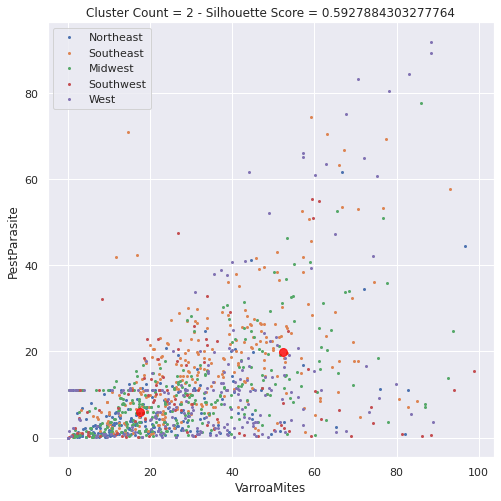

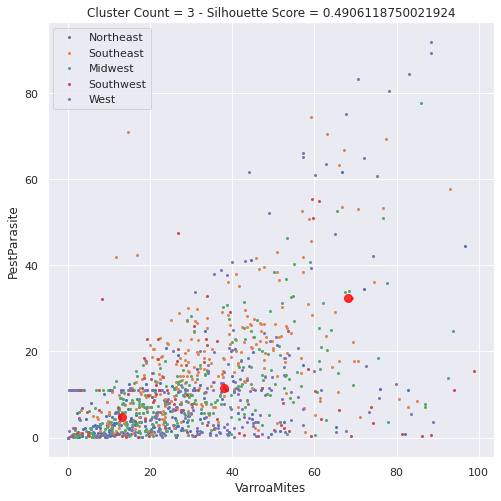

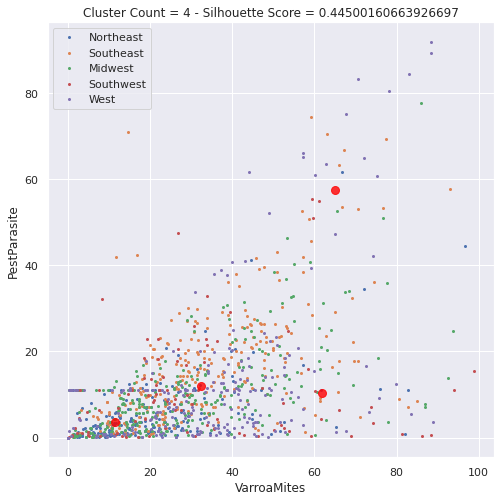

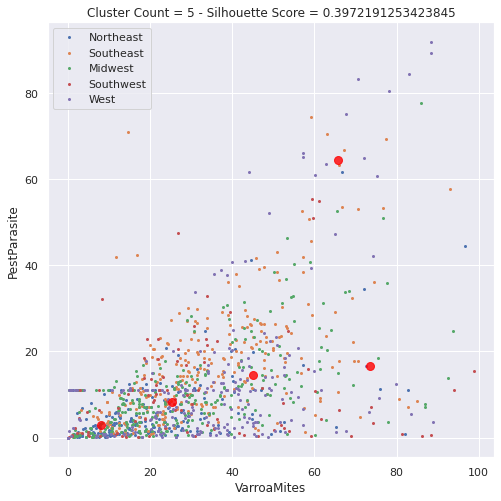

In [42]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
import pandas as pd

#Add regions the bee stressor dataframe
stressRegionDF = beeStressorDF.join(regionDF, on = "State")
stressRegionDF = stressRegionDF.na.fill(0)

va = VectorAssembler(inputCols = ['VarroaMites', 'PestParasite', 'Diseases','Pesticides','Other','Unknown'], outputCol = 'features')
indexer = StringIndexer(inputCol='Region', outputCol='RegionIndex')

evaluator = ClusteringEvaluator()
clusterCount = stressRegionDF.select(col("Region")).distinct().count()

for k in range(2, clusterCount + 1):
    kmeans = KMeans(k = k, weightCol='RegionIndex')

    pipeline = Pipeline(stages = [va, indexer, kmeans])

    pipeline_model = pipeline.fit(stressRegionDF)

    kmModel = pipeline_model.stages[2]

    centers = kmModel.clusterCenters()
    predictions = pipeline_model.transform(stressRegionDF)

    silhouette = evaluator.evaluate(predictions)
    
    
    pandasDF = predictions.select(
        'VarroaMites','PestParasite','prediction', 'Region').toPandas()

    fig, ax = plt.subplots(1, figsize = (8, 8))
    ax.set_xlabel('VarroaMites')
    ax.set_ylabel('PestParasite')
    ax.set_title("Cluster Count = " + str(k)  +  " - Silhouette Score = " + str(silhouette))
    for region in regions:
        temp = pandasDF[pandasDF.Region == region]
        plt.scatter(temp['VarroaMites'], temp['PestParasite'], s = 4, cmap='viridis', label = region)
    plt.scatter([c[0] for c in centers], 
                [c[1] for c in centers], c='red', s=64, alpha=0.8);
    plt.legend()




In [43]:
#Predictions
predictions.show()
predictions.orderBy('prediction').groupBy('prediction').pivot(
    'RegionIndex').count().show()

+-----+-----------+------------+--------+----------+-----+-------+-------+----+-------+---------+--------------------+-----------+----------+
|State|VarroaMites|PestParasite|Diseases|Pesticides|Other|Unknown|  YearQ|Year|Quarter|   Region|            features|RegionIndex|prediction|
+-----+-----------+------------+--------+----------+-----+-------+-------+----+-------+---------+--------------------+-----------+----------+
|Maine|        7.2|         2.6|    3.66|       6.5|  2.2|    2.1|2021-Q1|2021|     Q1|Northeast|[7.2,2.6,3.66,6.5...|        3.0|         4|
|Maine|       30.8|       11.11|     0.5|       6.5|  1.2|    0.6|2020-Q4|2020|     Q4|Northeast|[30.8,11.11,0.5,6...|        3.0|         0|
|Maine|       65.2|         2.5|     0.7|       6.5|  4.6|    6.2|2020-Q3|2020|     Q3|Northeast|[65.2,2.5,0.7,6.5...|        3.0|         1|
|Maine|       47.1|       11.11|    26.8|       6.5|  0.5|   4.18|2020-Q2|2020|     Q2|Northeast|[47.1,11.11,26.8,...|        3.0|         1|
|Maine

In [44]:
predictions = predictions.groupBy('Region','prediction').count()

+-------+----+-------+---------+----------+
| Region|Year|Quarter| Colonies|row_number|
+-------+----+-------+---------+----------+
|Midwest|2015|     Q1| 490500.0|         1|
|Midwest|2015|     Q2|1170500.0|         2|
|Midwest|2015|     Q3|1271500.0|         3|
|Midwest|2015|     Q4| 880500.0|         4|
|Midwest|2016|     Q1| 397500.0|         5|
|Midwest|2016|     Q2|1139000.0|         6|
|Midwest|2016|     Q3|1222000.0|         7|
|Midwest|2016|     Q4| 951000.0|         8|
|Midwest|2017|     Q1| 368800.0|         9|
|Midwest|2017|     Q2|1028000.0|        10|
+-------+----+-------+---------+----------+
only showing top 10 rows



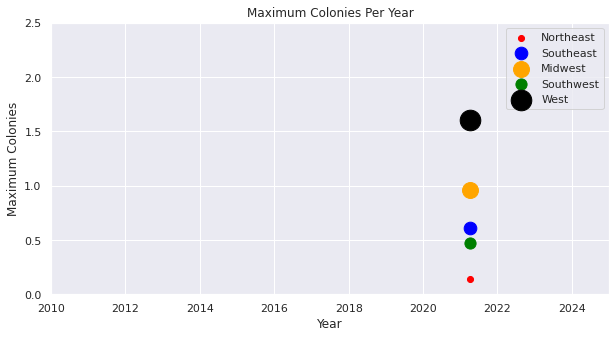

In [45]:
from itertools import count
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

beeData = beeColonyDF.join(regionDF, on = "State").select(["Region", "Year", "Quarter", "MaximumColonies"]).groupBy(["Region", "Year", "Quarter"]).sum()\
.withColumnRenamed("sum(MaximumColonies)", "Colonies")

beeData.na.fill(0)

#Use a window partition to order the quarters and year for each region
w  = Window.partitionBy(["Region"]).orderBy("Year", "Quarter")
beeData = beeData.withColumn("row_number",row_number().over(w))
beeData.show(10)
numOfQuarters = (beeData.select("row_number").rdd.max()[0])

td = beeData.filter(beeData.row_number == 1)
td = td.toPandas()
colonyList = [[]] * regionCount
c = count(0, 1)
#Build The Data
for region in regions.keys():
    i = next(c)
    tempData = beeData.filter(beeData.Region == region)
    tempData = tempData.toPandas()
    tempData['Colonies'] = tempData['Colonies'].fillna(0)
    regionData = tempData.Colonies
    colonyList[i] = regionData
xvals = []
#Build X variables
for region in regions.keys():
    tempData = beeData.filter(beeData.Region == region)
    tempData = tempData.toPandas()
    years = tempData.Year
    qs = tempData.Quarter
    xvals = [int(years[x]) + .25*int(qs[x][1])  - .25 for x in range(len(years))]
    
    
    #only need it once
    break
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
colors = ['red', 'blue', 'orange', 'green', 'black', 'yellow', 'grey', 'peru', 'blueviolet', 'violet', 'crimson']
keys = list(regions.keys())
def animate(t):  
    axes.cla()
    c = count(0, 1)
    x = xvals[t]
    y = []
    for i in range(len(colonyList)):
        y.append((colonyList[i][t])/1e6)
    for i in range(len(y)):
        size = 0 if y[i] == 0 else y[i]/sum(y)*1000
        axes.scatter(x, y[i], s = size, color=colors[i], label = keys[next(c)])
    axes.set_xlim([2010,2025])
    axes.set_ylim([0, 2.5])
    axes.set_xlabel("Year")
    axes.set_ylabel("Maximum Colonies")
    axes.set_title("Maximum Colonies Per Year")
    plt.legend()
   
    
anim = FuncAnimation(fig, func = animate, frames = numOfQuarters, interval=250)
HTML(anim.to_html5_video())



## Machine Learning Model Summary

In [ ]:
spark.stop()